In [48]:
from tokeniser import Tokeniser
from load_text import load_prideandprejudice, load_warandpeace
import os

# Create tokens

In [49]:
vocab_size = 1000 #Size of the vocabulary
vec_dim = 100
window_size = 8
epochs = 10
text_length = 50000
dataset = "warandpeace"
method = "cbow"

  0% (0 of 929) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (9 of 929) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10


Loading tokeniser from 'vocab_1000_warandpeace.json'...


  2% (23 of 929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:08
  3% (36 of 929) |                       | Elapsed Time: 0:00:00 ETA:   0:00:07
  5% (48 of 929) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06
  6% (59 of 929) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06
  7% (71 of 929) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
 10% (95 of 929) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04
 12% (118 of 929) |##                    | Elapsed Time: 0:00:00 ETA:   0:00:04
 15% (142 of 929) |###                   | Elapsed Time: 0:00:00 ETA:   0:00:04
 17% (165 of 929) |###                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 20% (189 of 929) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:03
 22% (212 of 929) |#####                 | Elapsed Time: 0:00:00 ETA:   0:00:03
 25% (236 of 929) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:02
 27% (259 of 929) |######               

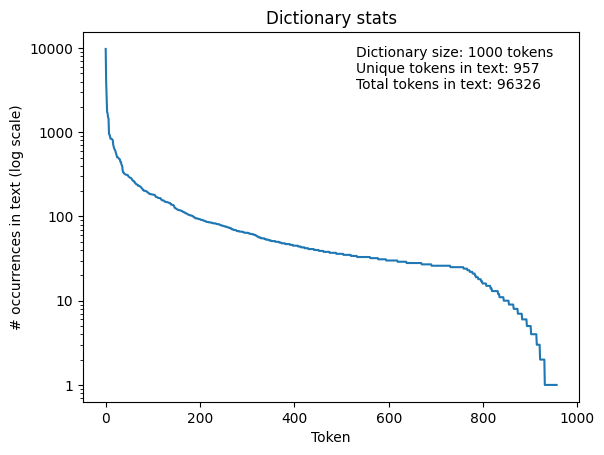

In [50]:
# Load text
tokeniser_savename = f'vocab_{str(vocab_size)}_{str(dataset)}.json'
text = load_prideandprejudice(text_length)

# Check if tokeniser has been saved to disk
if os.path.exists(tokeniser_savename):
    # Load tokeniser from disk
    print("Loading tokeniser from '%s'..." % (tokeniser_savename))
    tokeniser = Tokeniser.load(tokeniser_savename)
else:
    # Create a new tokeniser, train it on the text and save it to disk
    tokeniser = Tokeniser(vocab_size=vocab_size)
    print("Building BPE tokeniser...")
    tokeniser.train(text, verbose=True)
    print("Saving tokeniser to '%s'..." % (tokeniser_savename))
    tokeniser.save(tokeniser_savename)

ids = tokeniser.encode(text, verbose=True)
tokeniser.plot(ids=ids)


# Do Word 2 Vec

### Get Embeddings and save them to file

In [51]:
from tok2vec import tok2Vec
# x = model.get_embeddings()
tok2vec_savename = f'tok2vec_{vocab_size}_{vec_dim}_{text_length}_{window_size}_{epochs}_{method}_{dataset}'
# w, history = tok2Vec(vocab_size, ids, window_size, vec_dim, epochs, method=method, savename=tok2vec_savename)
tok2vec_model, history = tok2Vec(vocab_size, ids, window_size, vec_dim, epochs, method=method, savename=tok2vec_savename, load_from_file=False)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 100)               100000    
                                                                 
 dense_39 (Dense)            (None, 1000)              100000    
                                                                 
Total params: 200000 (781.25 KB)
Trainable params: 200000 (781.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
2708/2708 [==============================] - 5s 2ms/step - loss: 5.1977 - accuracy: 0.1720 - val_loss: 4.9545 - val_accuracy: 0.1935
Epoch 2/10
2708/2708 [==============================] - 4s 1ms/step - loss: 4.4748 - accuracy: 0.2278 - val_loss: 4.5430 - val_accuracy: 0.2178
Epoch 3/10
2708/2708 [==============================] - 4s 1ms/step - loss: 3.9502 - accuracy: 0.2701 - val_loss: 4.2782 

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
w_tok2vec = tok2vec_model.get_weights()[0]

w_tok2vec.shape

(1000, 100)

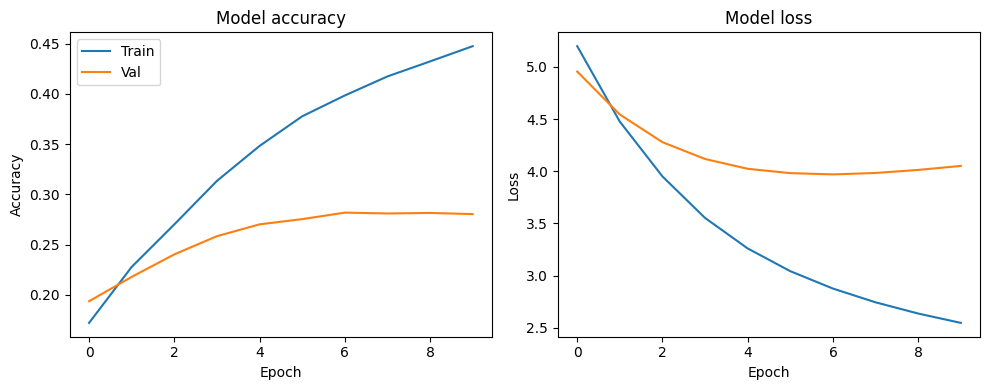

In [53]:
import matplotlib.pyplot as plt

# plot loss and accuracy side by side
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()


Plotting word vectors in 2D using t-SNE...


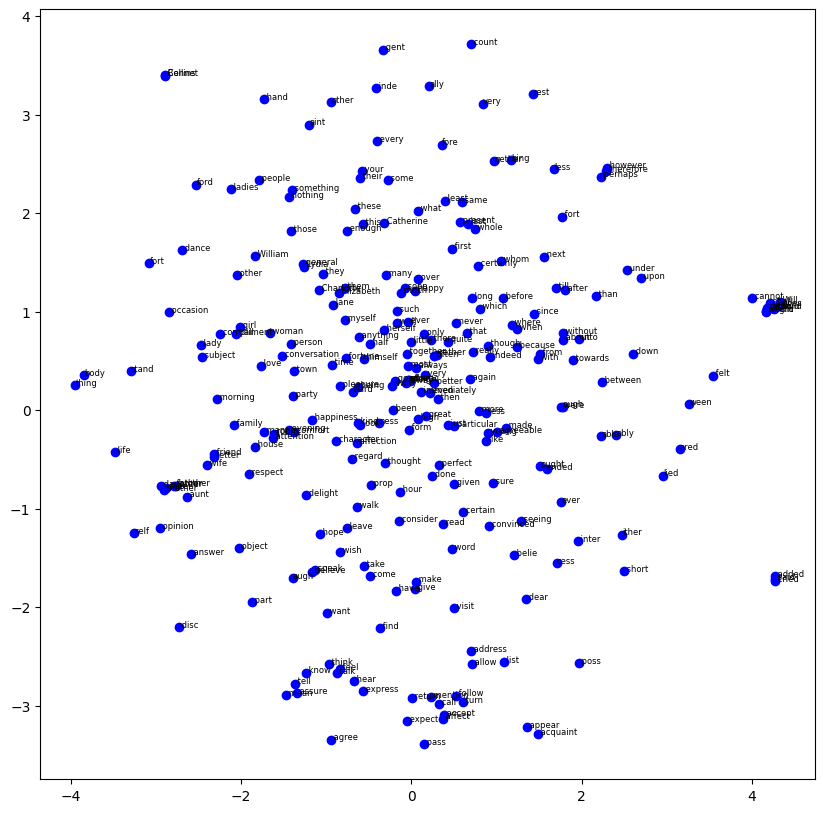

In [54]:
from tokeniser import plot_tok2vec
plot_tok2vec(w_tok2vec, tokeniser.word_index, num_words_to_show=500, figsize=(10, 10), fontsize=6)

# Transformer

In [61]:
from transformer import *

def get_bert_transformer(seq_len):
    vec_dim = 768    #Dimension of the embedding vectors

    tokeniser = Tokeniser.load_bert()
    vocab_size = tokeniser.vocab_size

    w_bert = tokeniser.get_embedding()
    print(str(w_bert.shape) + "\n")

    model = tf.keras.models.Sequential()
    model.add(FixedEmbedding(w_bert, seq_len))
    model.add(PositionalEncoding(vec_dim=vec_dim, seq_len=seq_len))
    model.add(TransformerLayer(vec_dim=vec_dim, key_dim=32, num_heads=8, dff=256))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

    learning_rate = CustomSchedule(vec_dim)
    opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                        epsilon=1e-9)

    model.compile(optimizer=opt,
                    loss=masked_loss,
                    metrics=[masked_accuracy])
    model.summary()
    return model

def get_custom_transformer(embedding, seq_len):
    model = tf.keras.models.Sequential()
    print(str(embedding.shape) + "\n")
    model.add(FixedEmbedding(embedding, seq_len))
    # model.add(OneHotEmbedding(vocab_size, seq_len))
    model.add(PositionalEncoding(vec_dim=vec_dim, seq_len=seq_len))
    model.add(TransformerLayer(vec_dim=vec_dim, key_dim=32, num_heads=8, dff=256))
    # model.add(TransformerLayer(vec_dim=vec_dim, key_dim=32, num_heads=8, dff=256))
    # model.add(TransformerLayer(vec_dim=vec_dim, key_dim=32, num_heads=8, dff=256))
    # model.add(TransformerLayer(vec_dim=vec_dim, key_dim=32, num_heads=8, dff=256))
    # model.add(TransformerLayer(vec_dim=vec_dim, key_dim=32, num_heads=8, dff=256))
    # model.add(TransformerLayer(vec_dim=vec_dim, key_dim=32, num_heads=8, dff=256))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

    learning_rate = CustomSchedule(vec_dim)
    opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                        epsilon=1e-9)

    model.compile(optimizer=opt,
                    loss=masked_loss,
                    metrics=[masked_accuracy])
    model.summary()
    return model

In [62]:
from transformer import *

seq_len = 128    
epochs = 5

n = len(ids)
train_ids = ids[:n*0.9]
val_ids = ids[n*0.9:]

train_data = predictTextDataGenerator(train_ids, seq_len, batch_size=32)
val_data = predictTextDataGenerator(val_ids, seq_len, batch_size=32)

# bert_transformer = get_bert_transformer(seq_len)
custom_transformer = get_custom_transformer(w_tok2vec, seq_len)
model.fit(train_data, validation_data=val_data, epochs=epochs)

(1000, 100)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fixed_embedding_18 (FixedE  (None, 128, 100)          0         
 mbedding)                                                       
                                                                 
 positional_encoding_10 (Po  (None, 128, 100)          0         
 sitionalEncoding)                                               
                                                                 
 transformer_layer_10 (Tran  (None, 128, 100)          155224    
 sformerLayer)                                                   
                                                                 
 dense_42 (Dense)            (None, 128, 1000)         101000    
                                                                 
Total params: 256224 (1000.88 KB)
Trainable params: 256224 (1000.88 KB)
Non-trainable params: 0 (0.00 Byte

In [64]:
import sys
def generate(prompt):
    print(prompt, end='')
    sys.stdout.flush()

    # Encode prompt to tokens
    tokens = tokeniser.encode(prompt)

    for i in range(1,100):
        # Check if prompt is more than seq_len, if so, truncate, grabbing the
        # last seq_len tokens
        if len(tokens) >= seq_len:
            tokens = tokens[-seq_len:]
        # Index of the last token, which is going to be the 
        # index of the output stream that we are going to use for prediction
        j = len(tokens)-1

        # If the prompt is less than seq_len, pad it with zeros
        if len(tokens) < seq_len:
            x = np.concatenate([tokens,np.zeros((seq_len-len(tokens)),dtype='int')], axis=0)
        else:
            x = np.array(tokens)

        # Since the transformer expect input to be of shape (num_examples, seq_len), and
        # at this point x is just a vector of seq_len integers, we need to add a dimension
        # to change x to a tensor of shape (1, seq_len)     
        x = np.expand_dims(x,axis=0)

        # Compute output of the transformer
        y = model.predict(x,verbose=False)
        # The output will be of dmension (1, seq_len, vocab_size), but we are only interested in
        # the token that follow the prompt, at position j in the output stream.  
        # And so y[:,j,:] is a (1, vocab_size) tensor of probabilities of the next token in the sequence.
        # and we want to find the token with the highest probability.
        y = np.argmax(y[:,j,:])
        
        # Decode the token back to text
        t = tokeniser.decode(y)
        # Print it
        print(t, end='')
        sys.stdout.flush()
        # Apend the token (integer) to the prompot tokens
        tokens.append(y)

    print("\n")

generate("Well, Prince, so Genoa and Lucca are now just family estates of the")

Well, Prince, so Genoa and Lucca are now just family estates of the

NotFoundError: Graph execution error:

Detected at node sequential_23/transformer_layer_9/multihead_self_attention_9/layer_normalization_18/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_29715/1039112954.py", line 47, in <module>

  File "/tmp/ipykernel_29715/1039112954.py", line 30, in generate

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2650, in predict

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2436, in predict_function

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2421, in step_function

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2409, in run_step

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2377, in predict_step

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filediwyu0gy.py", line 34, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/sequential.py", line 394, in call

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/sequential.py", line 397, in call

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/functional.py", line 514, in call

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/functional.py", line 661, in _run_internal_graph

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filediwyu0gy.py", line 34, in error_handler

  File "/home/jet/csoc420_assignment2/transformer.py", line 288, in call

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filediwyu0gy.py", line 34, in error_handler

  File "/home/jet/csoc420_assignment2/transformer.py", line 223, in call

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_filediwyu0gy.py", line 34, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/layers/normalization/layer_normalization.py", line 280, in call

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/layers/normalization/layer_normalization.py", line 342, in call

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tf_keras/src/layers/normalization/layer_normalization.py", line 343, in call

No registered '_MklLayerNorm' OpKernel for 'GPU' devices compatible with node {{node sequential_23/transformer_layer_9/multihead_self_attention_9/layer_normalization_18/add}}
	.  Registered:  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_FLOAT]

	 [[sequential_23/transformer_layer_9/multihead_self_attention_9/layer_normalization_18/add]] [Op:__inference_predict_function_388859]

: 